# Macroeconometrics Assignment 1

Disclaimer: some of the Greek letters in my Julia codes will appear as blanks (most notably the $\Psi$ and $\Phi$ in Assignment 3), as Visual Studio failed to export my markdown to PDF properly.

## Preamble

In [41]:
using Plots
using HypothesisTests
using GLM
using DataFrames
using StatsBase
using LinearAlgebra
using Distributions
using Dates
include("marketdata_functions.jl")

cd("/home/rinto/Desktop/Macroeconometrics/Assignment 1")

## Function Definition

In [42]:
# Construct a function which allows us to estimate a VAR(p) model 
function VAR(y, p)
    T = size(y, 1)
    k = size(y, 2)
    Y = y[p+1:end, :]
    X = [ones(T-p) [y[p + 1 - i:end - i, :] for i in 1:p]...]
    B̂ = inv(X'X)*X'Y
    ε̂ = Y - X*B̂
    Σ̂ = (ε̂'*ε̂)/(T - p)
    return B̂, Σ̂, ε̂
end

VAR(y::TimeArray, p) = VAR(values(y), p)

#=
function SequentialFTest(y, maxLags)
    res_unrestricted = VAR(y, (maxLags+1))[3]; 
    RSS_unrestricted = sum(res_unrestricted.^2);
    k_unrestricted = size(y, 2) * (size(y, 2) * (maxLags+1) + 1);
    T = size(y, 1);
    p_optimal = NaN;
    FScore = ones(maxLags);
    for i in 1:maxLags
        p = maxLags - i + 1;
        k_restricted = size(y, 2) * (size(y, 2) * p + 1);
        res_restricted = VAR(y, p)[3];
        RSS_restricted = sum(res_restricted.^2);
        FScore[i] = (RSS_restricted - RSS_unrestricted) / (RSS_unrestricted) * (T - k_unrestricted) / (k_unrestricted - k_restricted);
        critical_value = quantile(FDist(k_restricted - k_unrestricted, T - k_unrestricted), 1 - .5);
        if FScore[i] > critical_value && isnan(p_optimal)
            p_optimal = p;
        end
    end

    
    return FScore, p_optimal

end
=#


# This function seasonally adjusts the data
function seasonal_adjust(series::TimeArray)
    months = timestamp(series);
    months = Dates.month.(months);
    months = Char.(months);
    df = DataFrame([months, values(series)], [:MONTH, :SERIES]);
    model = lm(@formula(SERIES ~ MONTH), df)
    seasonal_component = predict(model) .- mean(values(series));
    seasonal_component = TimeArray(timestamp(series), seasonal_component)
    adjusted_series = series .- seasonal_component;
    
    return adjusted_series
    
end


# This function sequentially performs a Wald test up to maxLags
function SequentialWaldTest(y, maxLags)
    
    results = DataFrame(Lags = Int[], TestStat = Float32[], H0 = String[]);
    
    for i in 1:maxLags
        p = maxLags - i + 1;
        push!(results, (Lags = p, TestStat = WaldTest(y, p)[1][1], H0 = WaldTest(y, p)[2]));
    end

    return results

end


# This function performs a Wald test on lags number of lags
function WaldTest(y, lags)

    T = size(y, 1);
    k = size(y, 2);
    p = lags;
    
    B̂, Σ̂, ϵ̂  = VAR(y, p);
    β̂ = vec(B̂);
    X = [ones(T-p) [y[p + 1 - i:end - i, :] for i in 1:p]...];
    Γ̂  = X'X;
    A = Matrix(I, k*(k*p+1), k*(k*p+1)); # hypothesis matrix
    # A = A[1:end .∉ [[1, 1+(k*p+1), 1+2*(k*p+1)]], 1:end]; # exclude the intercepts from the hypotheses
    A = A[1:end .∉ [[1+i*(k*p+1) for i in 0:(k-1)]], 1:end]; # exclude the intercepts from the hypotheses
    c = zeros(size(A, 1), 1);

    denom = A * kron(Σ̂ , inv(Γ̂)) * A';
    num = (A * β̂ - c);
    W = num' * inv(denom) * num;
    
    critical_value = quantile(Chisq(size(A, 1)), 1 - .05);
    
    if W[1] > critical_value 
        H0 = "reject H0"
    else
        H0 = "fail to reject H0"
    end
    
    return W, H0
    
end

WaldTest(y::TimeArray, p) = WaldTest(values(y), p)


# This function performs an Akaike Information Criterion test up to maxLags
function AICTest(y, maxLags)
    T = size(y, 1);
    AIC = zeros(maxLags);
    results = DataFrame(Lags = Int[], AIC_Score = Float32[]);
    for i in 1:maxLags
        p = maxLags - i + 1;
        k = size(y, 2);
        Σ  = VAR(y, p)[2];
        AIC[i] = log(det(Σ)) + 2 / T * k * (p*k + 1);
        push!(results, (Lags = p, AIC_Score = AIC[i]));
    end

    optimal_p = maxLags - argmin(AIC) + 1;

    return results, optimal_p

end


# This function performs a Bayesian Information Criterion test up to maxLags
function BICTest(y, maxLags)
    T = size(y, 1);
    BIC = zeros(maxLags);
    results = DataFrame(Lags = Int[], BIC_Score = Float32[]);
    for i in 1:maxLags
        p = maxLags - i + 1;
        k = size(y, 2);
        Σ  = VAR(y, p)[2];
        BIC[i] = log(det(Σ)) + log(T) / T * k * (p*k + 1);
        push!(results, (Lags = p, BIC_Score = BIC[i]));
    end

    optimal_p = maxLags - argmin(BIC) + 1;

    return results, optimal_p

end

"""
This function decomposes B into μ and Φ, following slide 15 of lecture 1. 
    Here, Φ = [Φ₁, Φ₂, ..., Φₚ].
"""
function μΦ(B, k, p)
    μ = B[1, :]
    Φ = hcat([B[((i-1)*k:i*k - 1) .+ 2, :]' for i in 1:p]...)
    return μ, Φ
end


"""
    Construct F from Φ, following the formula in slide 14 of lecture 1.
"""
function F(Φ, k, p)
    F = [Φ; 
        I(k*(p-1)) zeros(k*(p-1), k)]
    return F
end


# We can use the functions constructed above to write a function which forecasts H steps ahead, 
# again following the formula in slide 14 of lecture 1.
function forecast(y, B̂, H)
    k = size(B̂, 2)
    p = (size(B̂, 1) - 1) ÷ k
    μ̂, Φ̂ = μΦ(B̂, k, p)
    FΦ̂ = F(Φ̂, k, p)
    d̂ = vcat(μ̂, zeros(k*(p - 1)))
    yT = vec(y[end:-1:end-(p-1), :]')
    ŷ = FΦ̂^H * yT +  sum([FΦ̂^i for i in 0:(H-1)])*d̂
    return ŷ[1:k]
end

forecast(y::TimeArray, B̂, H) = forecast(values(y), B̂, H)


# This function computes the forecast error
function forecast_error(Σ̂, B̂, H)
    k = size(B̂, 2)
    p = (size(B̂, 1) - 1) ÷ k
    Φ̂ = μΦ(B̂, k, p)[2]
    FΦ̂ = F(Φ̂, k, p)
    Σ̂ₕ = sum([FΦ̂^i * [Σ̂ zeros(k, k*(p-1)); zeros(k*(p-1), k) zeros(k*(p-1), k*(p-1))] * (FΦ̂^i)' for i in 0:(H-1)])
    return Σ̂ₕ[1:k, 1:k]
end

forecast_error (generic function with 1 method)

## Download Data

In [43]:
gdp = retrieve_marketdata(source = "fred", identifier = "NAEXKP01JPQ661S");
MarketData.rename!(gdp, :GDP);

interest = retrieve_marketdata(source = "fred", identifier = "IRSTCB01JPQ156N");
MarketData.rename!(interest, :SR);

deflator = retrieve_marketdata(source = "fred", identifier = "JPNGDPDEFQISMEI");
MarketData.rename!(deflator, :INF);

Time series for GDP, short-term interest and inflation (GDP deflator) have been downloaded. They cover the 01/04/1994 to 01/07/2023 and are at a quarterly frequency. 

## Plotting and Transformation

I begin by transforming some of the series. In particular, I seek to remove any unit roots to ensure that the series are stationary and the VAR is stable. I did not seasonally adjust the data, as the difference between the adjusted and unadjusted series were insignificant (see Appendix A). 

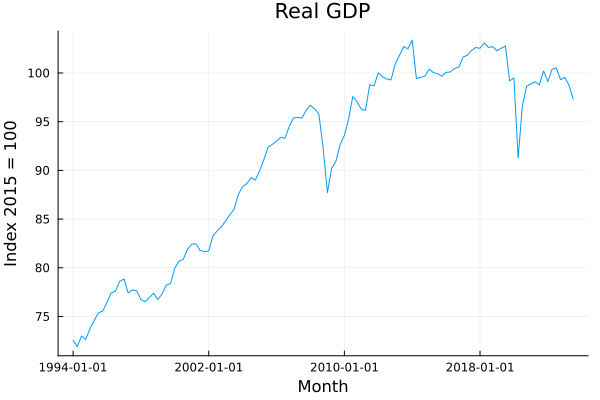

In [44]:
# calculate real GDP
rgdp = 100 .* gdp ./ deflator;
MarketData.rename!(rgdp, :RGDP);
gdp_plt = plot(rgdp, title = "Real GDP", xlabel = "Month", ylabel = "Index 2015 = 100", label = "real GDP", legend = false)

In [45]:
ADFTest(values(rgdp), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          0.00225656

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9706

Details:
    sample size in regression:          117
    number of lags:                     1
    ADF statistic:                      1.55442
    Critical values at 1%, 5%, and 10%: [-2.58478 -1.94348 -1.61476]


At first glance, the series for GDP look non-stationary and trending upwards. I test for the presence of unit roots using the augmented Dickey-Fuller test.

The series is upward trending and the ADF test indicates the presence of a unit root. Therefore, I take the first difference, interpreted as annualised quarterly GDP growth, to remove the trend and the unit root.

In [46]:
rgdp_growth = 400 .* diff(log.(rgdp));

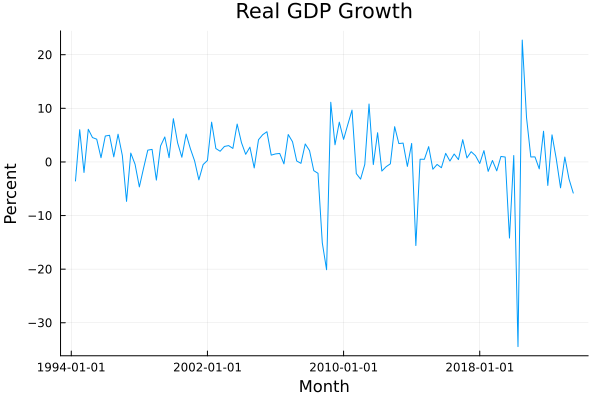

In [47]:
rgdp_growth_plt = plot(rgdp_growth, title = "Real GDP Growth", xlabel = "Month", ylabel = "Percent", legend = false)

In [48]:
ADFTest(values(rgdp_growth), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.908443

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-09

Details:
    sample size in regression:          116
    number of lags:                     1
    ADF statistic:                      -6.74729
    Critical values at 1%, 5%, and 10%: [-2.58495 -1.9435 -1.61475]


I reject the null hypothesis at a 5% confidence level, there is indeed no unit root. The series is stationary.

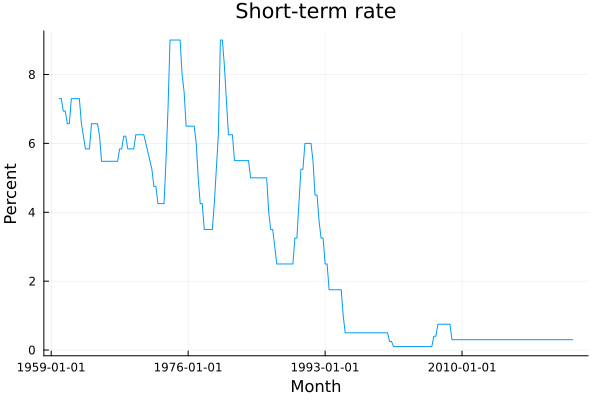

In [49]:
interest_plt = plot(interest, title = "Short-term rate", xlabel = "Month", ylabel = "Percent", legend = false)

In [50]:
ADFTest(values(interest), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.00984838

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.0612

Details:
    sample size in regression:          254
    number of lags:                     1
    ADF statistic:                      -1.8505
    Critical values at 1%, 5%, and 10%: [-2.57453 -1.9421 -1.61582]


I observe that the series is non-stationary and trending downwards. Therefore, I decided to detrend the series by taking the first difference.

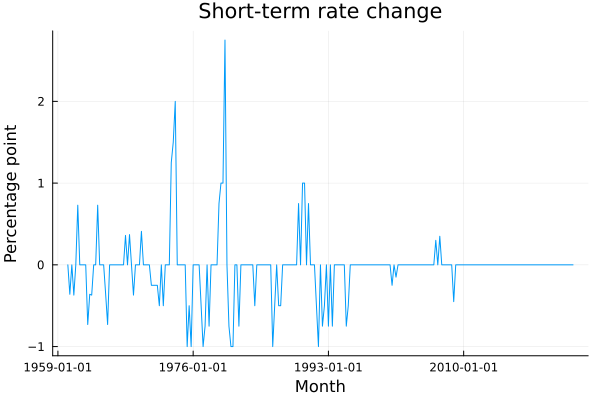

In [51]:
d1_interest = diff(interest);
d1_log_interest_plt = plot(d1_interest, title = "Short-term rate change", xlabel = "Month", ylabel = "Percentage point", legend = false)

In [52]:
ADFTest(values(d1_interest), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.503636

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-11

Details:
    sample size in regression:          253
    number of lags:                     1
    ADF statistic:                      -7.59338
    Critical values at 1%, 5%, and 10%: [-2.57456 -1.9421 -1.61582]


The ADF test rejects the null hypothesis at a 5% confidence level. Therefore, I decided to work with the first-differenced series for interest. 

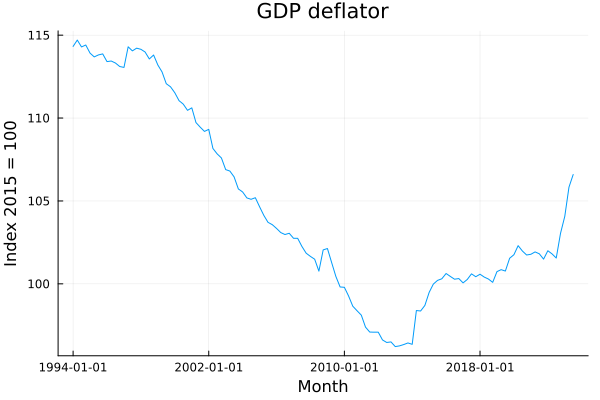

In [53]:
deflator_plt = plot(deflator, title = "GDP deflator", xlabel = "Month", ylabel = "Index 2015 = 100", legend = false)

In [54]:
ADFTest(values(deflator), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.000516854

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.2145

Details:
    sample size in regression:          117
    number of lags:                     1
    ADF statistic:                      -1.1886
    Critical values at 1%, 5%, and 10%: [-2.58478 -1.94348 -1.61476]


At first glance, the series looks non-stationary and trending downwards. Non-stationarity is confirmed by the ADF test. I therefore take the annualised percentage change in the GDP deflator, such that the transformed series is stationary and can be interpreted as inflation.

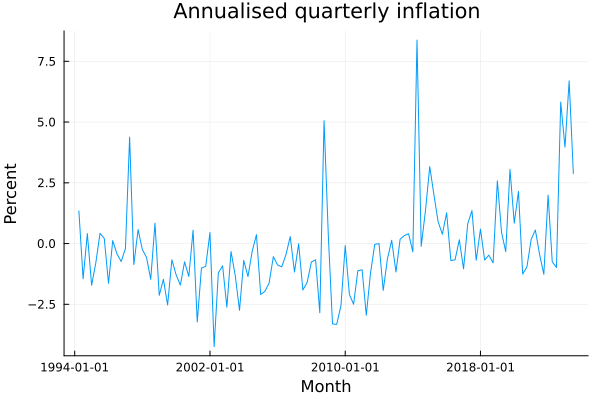

In [55]:
inflation = 400 .* diff(log.(deflator));
inflation_plt = plot(inflation, title = "Annualised quarterly inflation", xlabel = "Month", ylabel = "Percent", label = "inflation", legend = false)

In [56]:
ADFTest(values(inflation), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.525374

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-05

Details:
    sample size in regression:          116
    number of lags:                     1
    ADF statistic:                      -4.62184
    Critical values at 1%, 5%, and 10%: [-2.58495 -1.9435 -1.61475]


The series now looks stationary and contains no unit root, as shown by the ADF test. I collect all series into a single matrix.

In [57]:
y = merge(rgdp_growth, d1_interest, inflation)

118×3 TimeArray{Float64, 2, Date, Matrix{Float64}} 1994-04-01 to 2023-07-01
┌────────────┬──────────┬───────┬───────────┐
│            │ RGDP     │ SR    │ INF       │
├────────────┼──────────┼───────┼───────────┤
│ 1994-04-01 │ -3.55954 │   0.0 │   1.34016 │
│ 1994-07-01 │  6.01375 │   0.0 │  -1.44981 │
│ 1994-10-01 │ -1.96623 │   0.0 │  0.410174 │
│ 1995-01-01 │   6.0937 │   0.0 │  -1.71582 │
│ 1995-04-01 │  4.54818 │ -0.75 │ -0.800442 │
│ 1995-07-01 │  4.24462 │  -0.5 │  0.418847 │
│ 1995-10-01 │ 0.784423 │   0.0 │  0.215438 │
│ 1996-01-01 │  4.83483 │   0.0 │  -1.63431 │
│     ⋮      │    ⋮     │   ⋮   │     ⋮     │
│ 2022-01-01 │ -4.38598 │   0.0 │   1.99229 │
│ 2022-04-01 │   5.0538 │   0.0 │ -0.750041 │
│ 2022-07-01 │ 0.599997 │   0.0 │ -0.984222 │
│ 2022-10-01 │ -4.83018 │   0.0 │   5.82125 │
│ 2023-01-01 │  0.91131 │   0.0 │   3.96838 │
│ 2023-04-01 │  -3.1896 │   0.0 │   6.69585 │
│ 2023-07-01 │ -5.80522 │   0.0 │   2.87979 │
└────────────┴──────────┴───────┴───────────┘
    

## VAR Estimation

I begin by running a VAR(4) model and plotting the correlograms over 20 quarters for each equation.

In [58]:
# run a VAR(4) model
p = 4;
var4 = VAR(y, p);
res = var4[3];

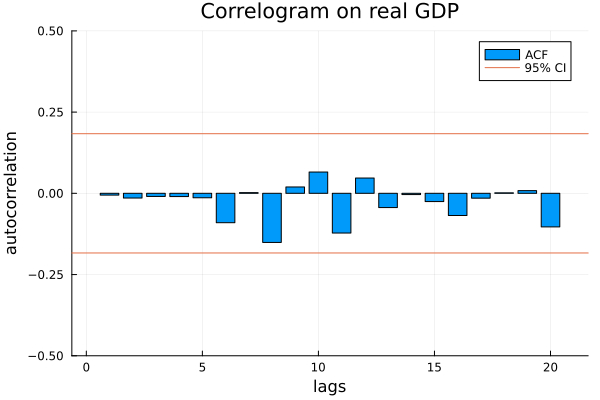

In [59]:
# GDP
gdp_res = res[:, 1];
bar(timestamp(y)[(p+1):end], gdp_res)
gdp_res_autocorr = autocor(gdp_res, collect(1:20); demean = true)
t = 1:length(gdp_res_autocorr);
CI_up = quantile(Normal(), 1 - .025) / sqrt(length(gdp_res));
CI_down = -CI_up;

bar(t, gdp_res_autocorr, ylims = [-.5, .5], title = "Correlogram on real GDP", xlabel = "lags", ylabel = "autocorrelation", label = "ACF")
hline!([CI_up, CI_down], label = "95% CI")

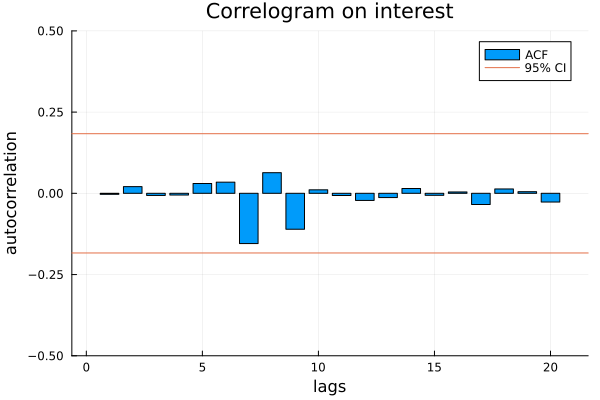

In [60]:
# interest
interest_res = res[:, 2];
bar(timestamp(y)[(p+1):end], interest_res)
interest_res_autocorr = autocor(interest_res, collect(1:20); demean = true)
t = 1:length(interest_res_autocorr);
CI_up = quantile(Normal(), 1 - .025) / sqrt(length(interest_res));
CI_down = -CI_up;

bar(t, interest_res_autocorr, ylims = [-.5, .5], title = "Correlogram on interest", xlabel = "lags", ylabel = "autocorrelation", label = "ACF")
hline!([CI_up, CI_down], label = "95% CI")

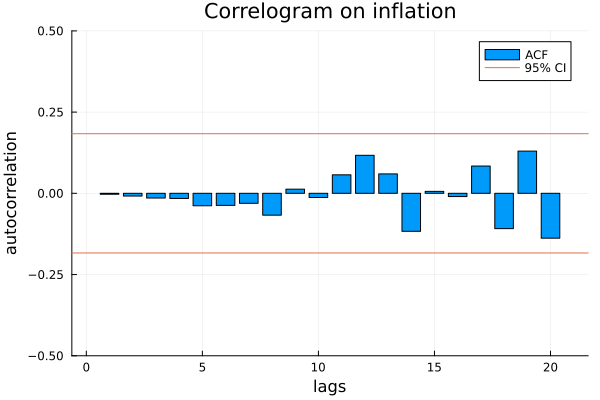

In [61]:
# inflation
inflation_res = res[:, 3];
bar(timestamp(y)[(p+1):end], inflation_res)
inflation_res_autocorr = autocor(inflation_res, collect(1:20); demean = true)
t = 1:length(inflation_res_autocorr);
CI_up = quantile(Normal(), 1 - .025) / sqrt(length(inflation_res));
CI_down = -CI_up;

bar(t, inflation_res_autocorr, ylims = [-.5, .5], title = "Correlogram on inflation", xlabel = "lags", ylabel = "autocorrelation", label = "ACF")
hline!([CI_up, CI_down], label = "95% CI")

We observe that the residuals on all equations are not persistent, with all autocorrelation values lying within the 95% confidence interval. Therefore, I expect VAR(p) with $p \leq 4$ to capture the series' data generating process.  

In [62]:
WaldTest(res, 12)

([142.42571435370743;;], "reject H0")

Running an F-test on the residuals of the VAR(4) with 12 lags rejects the null hypothesis that the residuals are uncorrelated up to 12 lags, suggesting that the model may need more lags to capture serial correlation.

## Determining the number of lags

In [63]:
maxLags = 12;
AICTest(y, maxLags)[1]

Row,Lags,AIC_Score
,Int64,Float32
1,12,-0.22991
2,11,-0.122021
3,10,-0.218105
4,9,-0.328344
5,8,-0.3128
6,7,-0.432149
7,6,-0.486755
8,5,-0.236651
9,4,0.26201


In [64]:
AICTest(y, maxLags)[2]

6

In [65]:
BICTest(y, maxLags)[1]

Row,Lags,BIC_Score
,Int64,Float32
1,12,2.37641
2,11,2.27298
3,10,1.96557
4,9,1.64401
5,8,1.44823
6,7,1.11756
7,6,0.851627
8,5,0.890407
9,4,1.17774


In [66]:
BICTest(y, maxLags)[2]

1

The AIC test suggests that 6 lags are optimal, while the BIC test suggests 1 lag. Since the Wald test on the residuals rejects the null hypothesis that the residuals are uncorrelated with 4 lags, I will follow the results produced by the AIC test and run a VAR(6) model.

## Forecast

I now estimate the two-quarter ahead forecast for real GDP growth using the coefficients from the VAR(6) estimated in the previous section. 

In [67]:
rgdp_growth = 400 .* diff(log.(rgdp));
y = merge(rgdp_growth, d1_interest, inflation);
B, Σ, ϵ = VAR(y, 6);

# forecast GDP up to two periods ahead and compute the corresponding standard error
H = collect(1:2);
yforecast = [forecast(y, B, i)[1] for i in H]
yforecast_error = sqrt.([forecast_error(Σ, B, i)[1,1] for i in H])

yforecast = [values(y)[end, 1]; yforecast];
yforecast_error = [0; yforecast_error];

dates = [timestamp(y)[end-11:end]; [timestamp(y)[end] + Month(3*i) for i in 1:2]]

yforecast = TimeArray(dates[end-2:end], yforecast)

3×1 TimeArray{Float64, 1, Date, Vector{Float64}} 2023-07-01 to 2024-01-01
┌────────────┬──────────┐
│            │ A        │
├────────────┼──────────┤
│ 2023-07-01 │ -5.80522 │
│ 2023-10-01 │  -7.7201 │
│ 2024-01-01 │ -8.21155 │
└────────────┴──────────┘

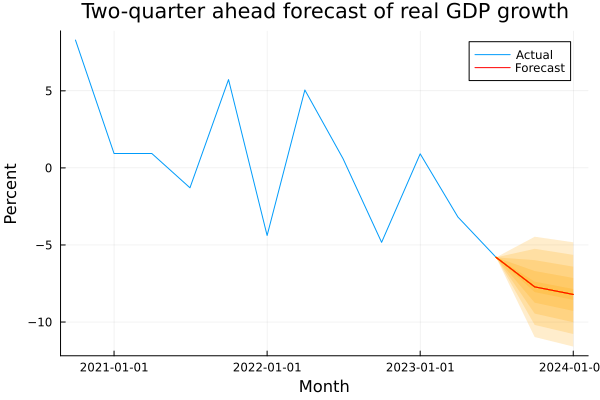

In [68]:
plot1 = plot(
    y[[:RGDP]][end-11:end], 
    title = "Two-quarter ahead forecast of real GDP growth",
    xlabel = "Month", 
    ylabel = "Percent", 
    label = "Actual", 
    legend = :topright)
for α in (0.95:-0.1:0.5)
    cα = quantile(Normal(), 1 - α/2)
    plot!(plot1, [yforecast yforecast], fillrange=[values(yforecast)+cα*yforecast_error values(yforecast)-cα*yforecast_error], fillalpha=0.2, c=:orange, label = "")
end
plot!(plot1, yforecast, label = "Forecast", c = :red)
plot1

At first glance, it appears likely that Japan enters a recession in 2023Q4 - 2024Q1.

## Calculating the probability of a recession

We are looking for the bivariate distribution of $(y_{1,T+1}|\hat{y}_{1,T+1|T},  y_{2,T+1}|\hat{y}_{2,T+1|T})$, which I derive in the notes following this markdown document. 

In [69]:
μ = [forecast(y, B, 1)[1], forecast(y, B, 2)[1]]

2-element Vector{Float64}:
 -7.720096866313475
 -8.21155085019172

In [70]:
#=
Φ₁₁ = B[1, 1];

Σ₀ = [forecast_error(Σ, B, 1)[1,1] Φ₁₁ * forecast_error(Σ, B, 1)[1,1] ;
        Φ₁₁ * forecast_error(Σ, B, 1)[1,1] forecast_error(Σ, B, 2)[1,1] ]
=#

Φ₁ = B[2:4, :];

Σ₀ = [forecast_error(Σ, B, 1)[1,1] (forecast_error(Σ, B, 1)* Φ₁')[1, 1] ;
        (forecast_error(Σ, B, 1)* Φ₁')[1, 1] forecast_error(Σ, B, 2)[1,1] ]

2×2 Matrix{Float64}:
 29.6421   -6.43588
 -6.43588  32.0294

I simulate a bivariate normal distribution which follows the properties described above. I then take the share of draws that are strictly negative to calculate the probability of a technical recession.

In [71]:
distr = MvNormal(μ, Σ₀);
n = 10000;
sample = rand(distr, n);

In [72]:
n_negative = sum(all(x .< 0) for x in eachcol(sample));
p_recession = n_negative / n

0.853

The model predicts an 85% probability that the Japanese economy enters a recession in 2023Q4 - 2024Q1. 

## Discussion

I identify four potential limitations to the above analysis. Firstly, the series that I used cover a relatively short period of time (01/04/1994 to 01/07/2023), such that my model quickly loses statistical power for each lag added to the VAR(p). This could result in lower accuracy while forecasting the probability of a recession, which might lead to an over-estimation of the probability of a recession if my point estimates are correct. In addition, I used iterated forecasting, which implies that an insufficient number of lags may lead to model misspecification and therefore, biased forecast. 

Secondly, the three variables used in the analysis may not be enough to predict the dynamics of GDP growth, leading to omitted variable bias. At the cost of efficiency, more variables could have been added to the VAR model, including industrial production, cost of credit, investment etc...

Thirdly, we may obtain more accurate forecasts by imposing some (valid) linear restrictions on the model by GLS. In particular, I did not test whether the series are homoskedastic, and using GLS instead of OLS to address heteroskedasticity (if it exists in the data) could improve the model's accuracy. 

Finally, I did not test for parameter stability and the existence of structural breaks, which might have led to biased forecast. Moreover (and on a related note), the assumption of linearity in the model ignores the possibility that a regime change might have happened in the sample period (e.g. the economy hits the ZLB), which might also have led to biased forecast.

## Appendix A: Seasonally adjusted vs unadjusted series

We barely observe any differences between the seasonally adjusted and unadjusted series.

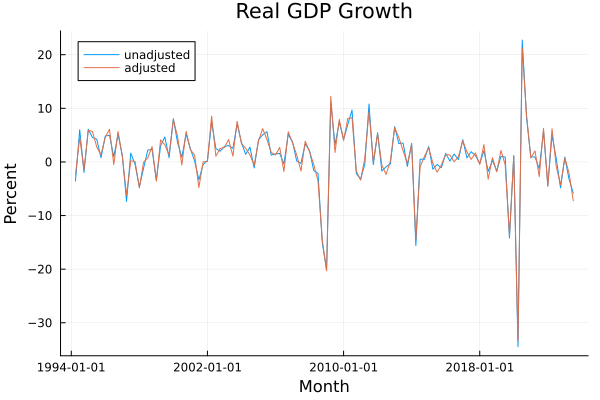

In [73]:
#plot(rgdp_growth, title = "Real GDP Growth", xlabel = "Month", ylabel = "Percent", legend = false)
plot(rgdp_growth, label = "unadjusted")
plot!(seasonal_adjust(rgdp_growth), label = "adjusted")
title!("Real GDP Growth")
xlabel!("Month")
ylabel!("Percent")

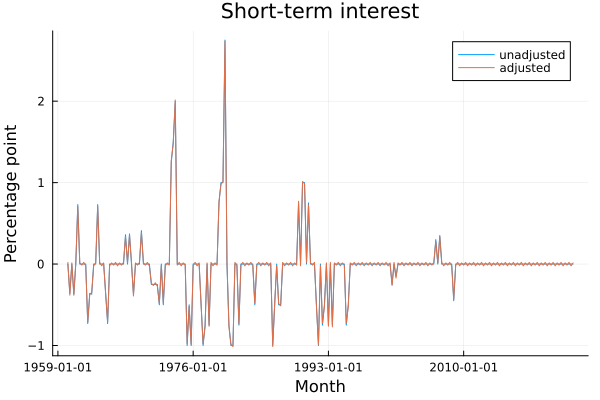

In [74]:
plot(d1_interest, label = "unadjusted")
plot!(seasonal_adjust(d1_interest), label = "adjusted")
title!("Short-term interest")
xlabel!("Month")
ylabel!("Percentage point")

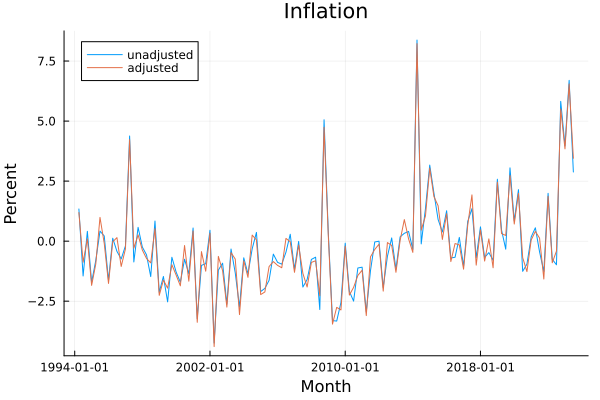

In [75]:
plot(inflation, label = "unadjusted")
plot!(seasonal_adjust(inflation), label = "adjusted")
title!("Inflation")
xlabel!("Month")
ylabel!("Percent")